In [4]:
!pip3 install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 18.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 16.2 MB/s eta 0:00:00


In [5]:
import hashlib
import math
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import pandas as pd

In [6]:
train_dir = Path('./train_dir/simpsons_dataset/')
test_dir = Path('./test_dir/kaggle_simpson_testset/')


def list_of_files(dir, with_aug=True):
    filename = '*/*.jpg'
    if with_aug:
        filename = '*/*.*'
    files_training = glob(os.path.join(dir, filename))
    print('Number of images in Training dir:', len(files_training))
    return files_training


list_of_files(train_dir)

Number of images in Training dir: 31015


['train_dir/simpsons_dataset/maggie_simpson/random_aug_pic346.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic420.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic434.png',
 'train_dir/simpsons_dataset/maggie_simpson/pic_0028.jpg',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic352.png',
 'train_dir/simpsons_dataset/maggie_simpson/pic_0000.jpg',
 'train_dir/simpsons_dataset/maggie_simpson/pic_0014.jpg',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic408.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic385.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic391.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic144.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic150.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic178.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic187.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic193.png',
 'train

In [7]:
CLASS_NAMES = []
for i in os.listdir(train_dir):
    if not i.startswith('.'):
        CLASS_NAMES.append(i)

In [8]:
def generate_md5_hash(file_path):
    with open(file_path, 'rb') as file:
        # Read the file contents
        data = file.read()

        # Calculate the MD5 hash
        md5_hash = hashlib.md5(data).hexdigest()

        return md5_hash

In [9]:
def remove_duplicate_from_dir(dir):
    hashes = {}
    files = glob(os.path.join(dir, '*.jpg'))
    for path in files:
        hash_image = generate_md5_hash(path)
        if hash_image not in hashes:
            hashes[hash_image] = []
        hashes[hash_image].append(path)
    duplicate_counter = 0
    for hash, images in hashes.items():
        if len(images) > 1:
            for image in images[1:]:
                os.remove(image)
                duplicate_counter += 1
    if duplicate_counter > 0:
        print(f"removed {duplicate_counter} duplicate from {dir}")

In [10]:
for dir in glob(os.path.join(train_dir, "*")):
    remove_duplicate_from_dir(dir)
for dir in glob(os.path.join(test_dir, "*")):
    remove_duplicate_from_dir(dir)

removed 1 duplicate from test_dir/kaggle_simpson_testset/charles_montgomery_burns
removed 1 duplicate from test_dir/kaggle_simpson_testset/chief_wiggum
removed 2 duplicate from test_dir/kaggle_simpson_testset/milhouse_van_houten
removed 8 duplicate from test_dir/kaggle_simpson_testset/lenny_leonard
removed 1 duplicate from test_dir/kaggle_simpson_testset/moe_szyslak
removed 4 duplicate from test_dir/kaggle_simpson_testset/edna_krabappel
removed 2 duplicate from test_dir/kaggle_simpson_testset/abraham_grampa_simpson
removed 2 duplicate from test_dir/kaggle_simpson_testset/krusty_the_clown
removed 2 duplicate from test_dir/kaggle_simpson_testset/nelson_muntz
removed 3 duplicate from test_dir/kaggle_simpson_testset/mayor_quimby
removed 3 duplicate from test_dir/kaggle_simpson_testset/kent_brockman
removed 3 duplicate from test_dir/kaggle_simpson_testset/bart_simpson
removed 3 duplicate from test_dir/kaggle_simpson_testset/homer_simpson


In [11]:
def items_per_class(dir):
    class_quantity = {i: 0 for i in CLASS_NAMES}
    for class_name in CLASS_NAMES:
        if not class_name.startswith('.'):
            class_path = os.path.join(dir, class_name)
            num_images = len(glob(os.path.join(class_path, '*.*')))
            class_quantity[class_name] += num_images
    return class_quantity

Total classes: 42
Items per class:
maggie_simpson 503
charles_montgomery_burns 1193
patty_bouvier 504
ralph_wiggum 504
chief_wiggum 986
milhouse_van_houten 1079
rainier_wolfcastle 506
cletus_spuckler 506
martin_prince 505
lenny_leonard 501
sideshow_bob 877
fat_tony 504
selma_bouvier 503
barney_gumble 502
lionel_hutz 192
gil 504
moe_szyslak 1452
carl_carlson 503
edna_krabappel 501
snake_jailbird 505
groundskeeper_willie 501
sideshow_mel 508
ned_flanders 1454
abraham_grampa_simpson 913
krusty_the_clown 1206
waylon_smithers 502
apu_nahasapeemapetilon 623
marge_simpson 1291
comic_book_guy 501
nelson_muntz 501
mayor_quimby 501
kent_brockman 501
professor_john_frink 505
principal_skinner 1194
bart_simpson 1342
lisa_simpson 1354
otto_mann 512
troy_mcclure 512
miss_hoover 502
disco_stu 512
homer_simpson 2246
agnes_skinner 504


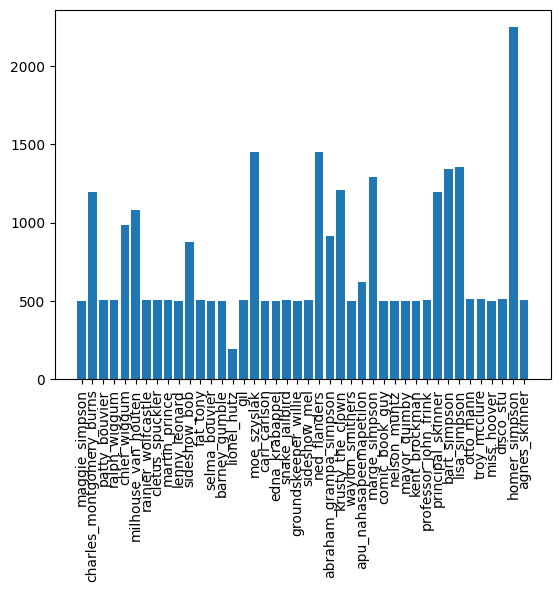

In [12]:
def print_classes_graph(dir):
    class_stat = items_per_class(dir)
    plt.bar(class_stat.keys(), class_stat.values(), align='center')
    plt.xticks(rotation=90)
    print(f"Total classes: {len(class_stat.keys())}")
    print(f"Items per class:")
    for key, value in class_stat.items():
        print(key, value)
    plt.show()


print_classes_graph(train_dir)

In [13]:
def get_low_quality_classes(left, right):
    low_quantity_classes = []
    class_stat = items_per_class(train_dir)
    for key, value in class_stat.items():
        if left <= value <= right:
            low_quantity_classes.append(key)
            print(key, value)

    print(f"Classes with items [{left}:{right}] : {len(low_quantity_classes)}")
    print(low_quantity_classes)
    return low_quantity_classes

In [14]:
def remove_augmentations():
    files_augmented = glob(os.path.join(train_dir, '*/aug*.png'))
    for file in files_augmented:
        os.remove(file)
    print("All augmentations removed: ", len(files_augmented))


def remove_all_random_augmentations():
    files_augmented = glob(os.path.join(train_dir, '*/random*.png'))
    for file in files_augmented:
        os.remove(file)
    print("All augmentations removed: ", len(files_augmented))

# remove_augmentations()
# remove_all_random_augmentations()

In [15]:
def apply_basic_aug():
    # flip_transform = transforms.Compose([transforms.PILToTensor(),
    #                                      transforms.RandomHorizontalFlip(p=1),
    #                                      transforms.ToPILImage()])
    # blur_transform = transforms.Compose([transforms.PILToTensor(),
    #                                      transforms.GaussianBlur(kernel_size=(25, 25), sigma=(0.2, 4.0)),
    #                                      transforms.ToPILImage()])
    blur_transform = transforms.GaussianBlur(kernel_size=(25, 25), sigma=(0.2, 4.0))
    flip_transform = transforms.RandomHorizontalFlip(p=1)

    classes = get_low_quality_classes(0, 30)

    for class_name in tqdm(classes):
        dir_path = os.path.join(train_dir, class_name)
        pictures = glob(os.path.join(dir_path, '*'))
        pic_number = len(pictures)
        for filename in pictures:
            image = Image.open(filename)
            path = os.path.join(dir_path, f"aug_pic{pic_number}.png")
            blurred = blur_transform(image)
            blurred.save(path)
            pic_number += 1
    print(f"blurred")

    for class_name in tqdm(classes):
        dir_path = os.path.join(train_dir, class_name)
        pictures = glob(os.path.join(dir_path, '*'))
        pic_number = len(pictures)
        for filename in pictures:
            image = Image.open(filename)
            path = os.path.join(dir_path, f"aug_pic{pic_number}.png")
            flipped = flip_transform(image)
            flipped.save(path)
            pic_number += 1
    print(f"flipped")


apply_basic_aug()

Classes with items [0:30] : 0
[]


0it [00:00, ?it/s]


blurred


0it [00:00, ?it/s]

flipped


In [16]:
classes = get_low_quality_classes(0, 500)
if len(classes) == 1:
    classes = []
for class_name in classes:
    dir_path = os.path.join(train_dir, class_name)
    pictures = glob(os.path.join(dir_path, '*'))
    pic_number = len(pictures)
    aug_per_pic = math.ceil((500 - pic_number) / pic_number)
    random_augment_transform = transforms.Compose([transforms.PILToTensor(),
                                                   transforms.RandAugment(num_ops=aug_per_pic + 2),
                                                   transforms.ToPILImage()])
    if aug_per_pic > 15:
        aug_per_pic = 15
    rand = transforms.RandAugment(num_ops=aug_per_pic + 2)
    for filename in tqdm(pictures):
        image = Image.open(filename)

        for i in range(aug_per_pic):
            path = os.path.join(dir_path, f"random_aug_pic{pic_number}.png")
            augmented = rand(image)
            augmented.save(path)
            pic_number += 1
        if pic_number > 500:
            break

lionel_hutz 192
Classes with items [0:500] : 1
['lionel_hutz']


Total classes: 42
Items per class:
maggie_simpson 503
charles_montgomery_burns 1193
patty_bouvier 504
ralph_wiggum 504
chief_wiggum 986
milhouse_van_houten 1079
rainier_wolfcastle 506
cletus_spuckler 506
martin_prince 505
lenny_leonard 501
sideshow_bob 877
fat_tony 504
selma_bouvier 503
barney_gumble 502
lionel_hutz 192
gil 504
moe_szyslak 1452
carl_carlson 503
edna_krabappel 501
snake_jailbird 505
groundskeeper_willie 501
sideshow_mel 508
ned_flanders 1454
abraham_grampa_simpson 913
krusty_the_clown 1206
waylon_smithers 502
apu_nahasapeemapetilon 623
marge_simpson 1291
comic_book_guy 501
nelson_muntz 501
mayor_quimby 501
kent_brockman 501
professor_john_frink 505
principal_skinner 1194
bart_simpson 1342
lisa_simpson 1354
otto_mann 512
troy_mcclure 512
miss_hoover 502
disco_stu 512
homer_simpson 2246
agnes_skinner 504


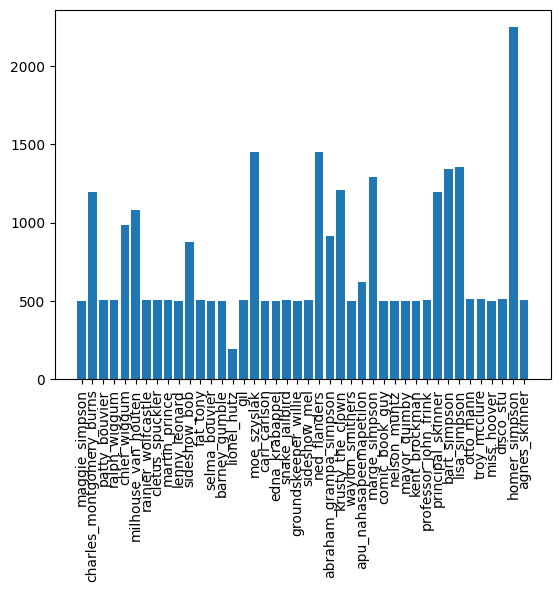

In [17]:
print_classes_graph(train_dir)

In [18]:
def calculate_mean_std(filenames):
    num_channels = 3
    dataset_mean = torch.zeros(num_channels)
    dataset_std = torch.zeros(num_channels)
    num_images = len(filenames)
    print('==> Computing mean and std..')
    for filename in tqdm(filenames):
        ToTensor = transforms.ToTensor()
        image_tensor = ToTensor(Image.open(filename))
        for i in range(num_channels):
            dataset_mean[i] += image_tensor[i, :, :].mean()
            dataset_std[i] += image_tensor[i, :, :].std()
    dataset_mean.div_(num_images)
    dataset_std.div_(num_images)
    print(f"Mean: {dataset_mean}")
    print(f"std: {dataset_std}")
    return dataset_mean, dataset_std

In [19]:
# files_training = list_of_files(train_dir, with_aug=False)
# result = calculate_mean_std(files_training)
total_mean, total_std = torch.tensor([0.4298, 0.3888, 0.3424]), torch.tensor([0.2325, 0.2168, 0.2363])
no_aug_mean, no_aug_std = torch.tensor([0.4622, 0.4075, 0.3524]), torch.tensor([0.2167, 0.1961, 0.2246])


In [20]:
from sklearn.model_selection import train_test_split

dataset_transform = transforms.Compose([transforms.Resize((256, 256)),
                                        transforms.CenterCrop(224), transforms.ToTensor(),
                                        transforms.Normalize(mean=total_mean, std=total_std)])
images_dataset = datasets.ImageFolder(
    root=train_dir, transform=dataset_transform
)

In [21]:
from torch.utils.data import SubsetRandomSampler


def get_loaders(dataset, batch_size=16):
    length = len(dataset)
    indicies = list(range(length))
    train_ind, val_ind = train_test_split(indicies, train_size=0.9, stratify=dataset.targets, shuffle=True, random_state=42)
    train_sampler = SubsetRandomSampler(train_ind)
    valid_sampler = SubsetRandomSampler(val_ind)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    return train_loader, validation_loader


In [24]:
num_epochs = 300
learning_rate = 0.001
batch_size = 16
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
min_valid_loss = np.inf

In [25]:
model = torchvision.models.resnet50(pretrained=False)
model_filename = "saved_model.pth"
if model_filename in os.listdir():
    model.load_state_dict(torch.load(model_filename,map_location=torch.device(device)))

# Set the model to run on the device
model = model.to(device)

train_loader, validation_loader = get_loaders(images_dataset, batch_size=batch_size)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:

# Train the model...
for epoch in range(num_epochs):
    print(f"Running {epoch + 1} epoch")
    train_loss = 0.0
    model.train()
    for inputs, labels in tqdm(train_loader):
        # Move input and label tensors to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zero out the optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss = loss.item() * inputs.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
    valid_loss = 0.0
    model.eval()  # Optional when not using Model Specific layer
    for inputs, labels in tqdm(validation_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        target = model(inputs)
        loss = criterion(target, labels)
        valid_loss = loss.item() * inputs.size(0)
    # Print the loss for every epoch
    print(
        f'Epoch {epoch + 1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(validation_loader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')

print(f'Finished Training, Loss: {loss.item():.4f}')

In [26]:
images_dataset.class_to_idx

{'abraham_grampa_simpson': 0,
 'agnes_skinner': 1,
 'apu_nahasapeemapetilon': 2,
 'barney_gumble': 3,
 'bart_simpson': 4,
 'carl_carlson': 5,
 'charles_montgomery_burns': 6,
 'chief_wiggum': 7,
 'cletus_spuckler': 8,
 'comic_book_guy': 9,
 'disco_stu': 10,
 'edna_krabappel': 11,
 'fat_tony': 12,
 'gil': 13,
 'groundskeeper_willie': 14,
 'homer_simpson': 15,
 'kent_brockman': 16,
 'krusty_the_clown': 17,
 'lenny_leonard': 18,
 'lionel_hutz': 19,
 'lisa_simpson': 20,
 'maggie_simpson': 21,
 'marge_simpson': 22,
 'martin_prince': 23,
 'mayor_quimby': 24,
 'milhouse_van_houten': 25,
 'miss_hoover': 26,
 'moe_szyslak': 27,
 'ned_flanders': 28,
 'nelson_muntz': 29,
 'otto_mann': 30,
 'patty_bouvier': 31,
 'principal_skinner': 32,
 'professor_john_frink': 33,
 'rainier_wolfcastle': 34,
 'ralph_wiggum': 35,
 'selma_bouvier': 36,
 'sideshow_bob': 37,
 'sideshow_mel': 38,
 'snake_jailbird': 39,
 'troy_mcclure': 40,
 'waylon_smithers': 41}

Total classes: 42
Items per class:
maggie_simpson 0
charles_montgomery_burns 47
patty_bouvier 0
ralph_wiggum 0
chief_wiggum 49
milhouse_van_houten 47
rainier_wolfcastle 0
cletus_spuckler 0
martin_prince 0
lenny_leonard 42
sideshow_bob 47
fat_tony 0
selma_bouvier 0
barney_gumble 0
lionel_hutz 0
gil 0
moe_szyslak 49
carl_carlson 0
edna_krabappel 46
snake_jailbird 0
groundskeeper_willie 0
sideshow_mel 0
ned_flanders 49
abraham_grampa_simpson 46
krusty_the_clown 48
waylon_smithers 0
apu_nahasapeemapetilon 50
marge_simpson 50
comic_book_guy 49
nelson_muntz 48
mayor_quimby 47
kent_brockman 47
professor_john_frink 0
principal_skinner 50
bart_simpson 47
lisa_simpson 50
otto_mann 0
troy_mcclure 0
miss_hoover 0
disco_stu 0
homer_simpson 47
agnes_skinner 0


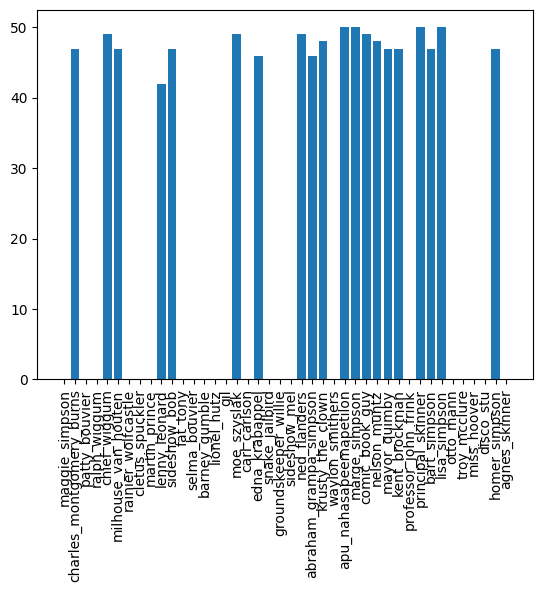

In [27]:
print_classes_graph(test_dir)

In [28]:
test_dataset = datasets.ImageFolder(
    root=test_dir, transform=dataset_transform
)

In [29]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                                shuffle=True)

In [30]:
y_true = []
y_pred = []
with torch.no_grad():
    model.eval()
    for inputs, labels in tqdm(test_loader):
        y_true.extend(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        
        outputs = outputs
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())


100%|███████████████████████████████████████████| 60/60 [00:08<00:00,  7.14it/s]


In [45]:
print(y_true[0])
print(y_pred[0])

tensor(9)
17


In [42]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

In [43]:
dataframe = pd.DataFrame(cf_matrix)

In [44]:
dataframe

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,42,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,49,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,46,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,47,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,45,0,0,...,0,0,0,1,2,0,0,0,0,0
5,0,0,0,1,0,0,1,0,0,41,...,0,0,0,0,1,0,0,1,0,3
6,0,0,3,2,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
